## Handwritten Classification to Solve CAPTCHAs

# Names

- George Liu, A15836054
- Xinyao Yi, A59019592
- Yingnan Yang, A16018172

# Abstract 

Our goal is to build multiple models that accurately classfies handwritten digits and letters and select the best model through understanding how different hyperparameters affect the predictions. From the best model, we will try to solve scrambled number captchas to see how the model performs. 

We plan to use the MNIST handwritten dataset, which holds data for more than 70,000 images. With our data, we plan to build a baseline model using the k-NN algorithm as well as a fully connected neural network, and then evaluate the error through a variety of metrics, and finally choosing one based on both performance as well as usefulness in the real world (some metrics don't make logical sense b/c of the dataset structure). We will combine this dataset with the EMNIST dataset, which is organized the same way, but consists of 70,0000 handwritten letters.

After all this, we will apply our model onto CAPTCHAs that we will build using opencv, by rotating/transforming integer CAPTCHAs to test how accurate the model performs.

# Background

Prior work using this dataset has included deep learning optimization of learning rates, attacks/defenses on adversial training, and large margin classification. In our project, we aim to distiguish the difference between different hyperparameters, including but not limited to speed and accuracy. We test optimizers like rmsprop, adam, and sgd, which are usually variant in speed and generalization but not always (and can also largely depend on the learning rate). This is important for proof of convergence, and dynamic bounds, which in theory are good ideas but need to be tested on simpler, small scale models before being able to be understood and predict how they will react on large scale projects <sup>[1](#adaptivelearningrate)</sup>. In addition, handwritten digits can also be expanded into a broader topic of just handwritten words, and how to classify that. This includes ideas such as encoder/decoder neural networks, which all the parameters build upon the backs of more basic models like our handwritten digit classifiers <sup>[2](#handwritten)</sup>. Since the logic from building ground up is the same, being able to identify which parameters are important to use and how to choose them in our digit classifier is key to success in larger projects.






# Research Problem

Sometimes, when we log into shopping websites or bank accounts online, we are greeted with a CAPTCHA to solve. We want to test how effective these CAPTCHAs actually are at filtering out non human activity. Since we trained our model on both MNIST and EMNIST dataset, our model should theoretically be able to solve CAPTCHA tests.

Testing different models with different hyperparameters not only helps determinine the similarity between distinct handwritten digits, but also to understand the different hyperparameters used in our model and how to predict results from them in order to tell when they are useful for further projects.

To directly solve our research problem, we will test our model on the CAPTCHAs to see how the model performs.

# Data

Our data is the MNIST dataset which can easily downloaded through tensorflow and keras, which is what we are going to use.
Each observation consists of a handwritten digit which can be from 0-9, size 28x28 pixels and 70,000 total images. Here is a link to the [dataset.](https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image_classification/mnist.py)
Similarly, the EMNIST dataset is available through torchvision. We can download the dataset from there, but need to split the data as well as combine both these datasets together.

We will need to normalize the images, meaning rescaling the pixel values so that they are all consistent. Since we are dealing with images, we can just use the pixels as our range. The max value of a pixel is 255, so if we divide each image by 255, the pixels should all be in the range of 0-1.

Additionally, the dataset is huge. For knn, this means our training is going to take forever, which is why we randomly sampled a subset of images from the train,val,test sections. We plan to adjust this as we go along. 

For the neural network, we probably will take a similar approach in sampling the data, but because it is a different model, the training time will differ. Therefore, we will decide when we implement it.



### Sampling
Both of our datasets are huge, which means training kNN is super inefficient. Below we will randomly sample n number of images from the dataset to help speed up the process. With a better GPU and more time, we could use all the data.

In [1]:
def get_subset_dataset(n_samples,x,y):
    """
    This function simply gets a random subset of n_samples from the dataset. Useful for EMNIST dataset to get a smaller portion
    """
    # needs to be indicies else the relationship between X and y is lost
    idx = np.random.choice(x.shape[0], n_samples, replace=False)
    idx = np.sort(idx)
    return x[idx],y[idx]

In [2]:
def get_subset(n_samples, x, y):
    """
    This function gets a random subset of n_samples FROM EACH CLASS in the dataset. Used on the combined dataset
    """
    # Find the unique classes in y
    classes = np.unique(y)
    # Initialize empty arrays to hold the samples
    x_samples = np.empty((0, x.shape[1]), dtype=x.dtype)
    y_samples = np.empty((0,), dtype=y.dtype)
    # Loop through each class and sample n_samples
    for c in classes:
        idx = np.where(y == c)[0]
        x_c, y_c = get_subset_dataset(n_samples, x[idx], y[idx])
        x_samples = np.concatenate((x_samples, x_c), axis=0)
        y_samples = np.concatenate((y_samples, y_c), axis=0)
    return x_samples, y_samples

In [3]:

# def get_subset(n_samples, x, y):
#     """
#     This function gets a random subset of n_samples FROM EACH CLASS in the dataset. Used on the combined dataset
#     """
#     # Find the unique classes in y
#     classes = np.unique(y)
#     # Initialize empty arrays to hold the samples
#     x_samples = np.empty((0, x.shape[1]), dtype=x.dtype)
#     y_samples = np.empty((0,), dtype=y.dtype)
#     # Loop through each class and sample n_samples
#     for c in classes:
#         idx = np.where(y == c)[0]
#         idx_samples = np.random.choice(idx, n_samples, replace=False)
#         x_c = x[idx_samples]
#         y_c = y[idx_samples]
#         x_samples = np.concatenate((x_samples, x_c), axis=0)
#         y_samples = np.concatenate((y_samples, y_c), axis=0)
#     return x_samples, y_samples

#### Preprocessing EMNIST dataset

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Define the data transformation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])


# Load the EMNIST dataset
emnist_trainset = torchvision.datasets.EMNIST(root='./data', split='letters', train=True,
                                              download=True, transform=transform)
emnist_testset = torchvision.datasets.EMNIST(root='./data', split='letters', train=False,
                                             download=True, transform=transform)

In [5]:
x_train_emnist = emnist_trainset.data.numpy().astype('float32') / 255.0
x_test_emnist = emnist_testset.data.numpy().astype('float32') / 255.0
y_train_emnist = emnist_trainset.targets.numpy()
y_test_emnist = emnist_testset.targets.numpy()

In [6]:
x_train_emnist = np.expand_dims(x_train_emnist, axis=3)
x_test_emnist = np.expand_dims(x_test_emnist, axis=3)

In [7]:
x_train_emnist = np.squeeze(x_train_emnist, axis=3)
x_test_emnist = np.squeeze(x_test_emnist, axis=3)

In [8]:
x_train_emnist, y_train_emnist = get_subset_dataset(60000,x_train_emnist,y_train_emnist)
x_test_emnist, y_test_emnist = get_subset_dataset(10000,x_test_emnist,y_test_emnist)
# NOTE: THIS LINE IS SUPER IMPORTANT OTHERWISE MNIST DIGITS WILL OVERWRITE THESE LABELS
y_train_emnist += 10
y_test_emnist += 10

In [9]:
print("Training set shape:", x_train_emnist.shape, y_train_emnist.shape)
print("Testing set shape:", x_test_emnist.shape, y_test_emnist.shape)

Training set shape: (60000, 28, 28) (60000,)
Testing set shape: (10000, 28, 28) (10000,)


In [10]:
np.unique(y_train_emnist)

array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36])

#### Preprocessing MNIST dataset

In [11]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

2023-03-04 02:20:21.648310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 02:20:23.835143: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-04 02:20:23.835336: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-04 02:20:23.835358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [12]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
x_train_mnist = x_train_mnist.astype('float32') / 255.0
x_test_mnist = x_test_mnist.astype('float32') / 255.0
print("Training set shape:", x_train_mnist.shape, y_train_mnist.shape)
print("Testing set shape:", x_test_mnist.shape, y_test_mnist.shape)

Training set shape: (60000, 28, 28) (60000,)
Testing set shape: (10000, 28, 28) (10000,)


In [13]:
np.unique(y_train_mnist)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### Combining Datasets

In [14]:
x_train = np.concatenate((x_train_mnist, x_train_emnist), axis=0)
y_train = np.concatenate((y_train_mnist, y_train_emnist), axis=0)
x_test = np.concatenate((x_test_mnist, x_test_emnist), axis=0)
y_test = np.concatenate((y_test_mnist, y_test_emnist), axis=0)

In [15]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [16]:
def convert_shape(matrix):
    """
    takes in a nx28x28 matrix and converts it into nx784, essentially flattening the array
    """
    samples = matrix.shape[0]
    features = matrix.shape[1] * matrix.shape[2]
    return matrix.reshape(samples, features)

In [17]:
x_train = convert_shape(x_train)
x_test = convert_shape(x_test)

In [18]:
# Getting a subset of dataset for KNN
num_samples_per_class = 200
x_train_subset, y_train_subset = get_subset(num_samples_per_class, x_train,y_train)
x_test_subset, y_test_subset = get_subset(num_samples_per_class, x_test, y_test)

In [19]:
x_train_subset.shape

(7200, 784)

# Proposed Solution


Since our training data is plentiful, we will first use k-NN as our benchmark model. Our solution is to convert and normalize the images into feature vectors by flattening the image, and then creating a datastructure for all these vectors so it will be efficient to pull out the labels during the test period. Next, we will have to choose different values of k to tune the hyperparameters, and then choose the best k value based on our evaluation metrics.

Next, for our neural network, we can just use the same data from our knn model as its been preprocessed. Then, we will design the architecture of the model. We will use adam for our optimizer and the softmax function as our activation function, since it will represent probability for each class. Then, we will compare the predicted label with the true label to see if the loss function is necessary, then finally update the parameters of the model.

Finally, we will have to use openCV to alter some of the CAPTCHA tests to only include integers. Then, we can apply things like scaling, rotation, and transformations to test how our model performs on these tests to answer our research question on if CAPTCHA can accurately detect human vs. non human interactions.

# Evaluation Metrics


We are training our handwritten model to test on CAPTCHA. This means that we want to have good balance between precision and recall, which is why F1 score is the best way to evalute our model. For example, if we used an imbalanced model, there would probably be a few digits that the model would be able to predict very well on, and not good on others. So when actually tested in CAPTCHA, the model would only be able to pass specific tests and wouldn't be generalizable. In terms of the f1 score mathematically represented, we just plan to use it how we derived in class, which is (2* Precision *Recall)/(Precision+Recall).


We did not choose accuracy as our error metric, because of the possiblity of imbalanced classes in our data. For kNN, we sampled the data randomly so there possibly could be more samples of some digit compared to another, which would skew our accuracy. This isn't a problem for our neural network implementation, but just in case F1 is still the better choice.
Something to note is the inherent error in some digits, for example the way 3 and 8 are written are very close, as well as 4 and 9 and 1 and 7. This means that accuracy isn't a great metric, because inside of a high accuracy there could be high error rates for some classes and low error rates for other classes. Using f1 score would be a good solution to this, as well as displaying the error rates for each class.

For our final results to answer our research problem, we will just evaluate the model's performance on CAPTCHAs using accuracy, whether the model passes the test or not.


# Preliminary results



In [20]:
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [21]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_subset, y_train_subset)
y_pred_test = knn.predict(x_test_subset)

In [22]:
cm = confusion_matrix(y_test_subset, y_pred_test)

#### Getting Some Error Metrics

In [23]:
def get_error_counts(conf_matrix):
    num_classes = conf_matrix.shape[0]
    error_counts = []
    for i in range(num_classes):
        digit_errors = 0
        for j in range(num_classes):
            if i != j:
                digit_errors += conf_matrix[j][i]
        error_counts.append(digit_errors)
    return error_counts

In [24]:
def get_error_metrics(conf_matrix):
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN
    return TP,FP,FN,TN

In [25]:
def get_accuracy_rate(conf_matrix):
    TP,FP,FN,TN = get_error_metrics(conf_matrix)
    return (TP + TN) / (TP + TN + FP + FN)

In [26]:
def get_F1_score(conf_matrix):
    TP,FP,FN,TN = get_error_metrics(conf_matrix)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return (2 * precision * recall) / (precision + recall)

#### Accuracy of Baseline kNN:

In [27]:
accuracies = get_accuracy_rate(cm)
accuracies

array([0.98666667, 0.98861111, 0.98972222, 0.99180556, 0.9925    ,
       0.99263889, 0.99541667, 0.99305556, 0.99305556, 0.99152778,
       0.97666667, 0.9875    , 0.98416667, 0.98597222, 0.98875   ,
       0.98263889, 0.97763889, 0.98347222, 0.96555556, 0.98777778,
       0.98666667, 0.96597222, 0.99458333, 0.98305556, 0.98055556,
       0.98708333, 0.97875   , 0.98347222, 0.99444444, 0.98430556,
       0.98680556, 0.98736111, 0.99430556, 0.99013889, 0.98569444,
       0.99444444])

In [28]:
# split between digit and letter to better visualize
digit_acc = accuracies[:10]
letter_acc = accuracies[10:]

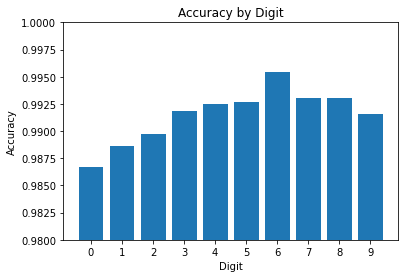

In [29]:
# Plot accuracy by digit
plt.bar(range(10), digit_acc)
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Accuracy by Digit')
plt.ylim(0.98, 1.0)
plt.xticks(range(10), range(10))
plt.show()

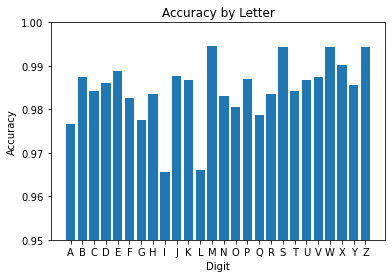

In [30]:
alphabet = [chr(i) for i in range(65, 91)]
# Plot accuracy by letter
plt.bar(range(26), letter_acc)
plt.xticks(range(26), alphabet)
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Accuracy by Letter')
plt.ylim(0.95, 1.0)
plt.show()

#### F1 Score of Baseline kNN:

In [31]:
F1_score = get_F1_score(cm)
digit_F1_score = F1_score[:10]
letter_F1_score = F1_score[10:]

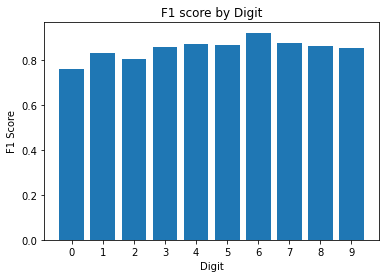

In [37]:
# Plot accuracy by digit
plt.bar(range(10), digit_F1_score)
plt.xlabel('Digit')
plt.ylabel('F1 Score')
plt.title('F1 score by Digit')
plt.xticks(range(10), range(10))
plt.show()

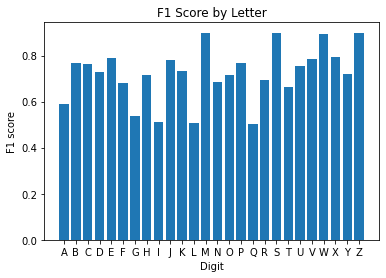

In [38]:
alphabet = [chr(i) for i in range(65, 91)]
# Plot accuracy by letter
plt.bar(range(26), letter_F1_score)
plt.xticks(range(26), alphabet)
plt.xlabel('Digit')
plt.ylabel('F1 score')
plt.title('F1 Score by Letter')
plt.show()

#### Visualization of Confusion matrix and Errors by Digit:

<AxesSubplot:>

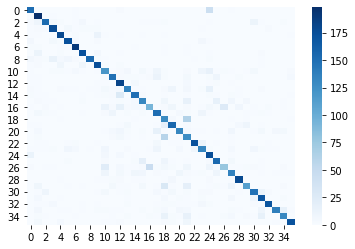

In [34]:
sns.heatmap(cm, annot=False, cmap='Blues')

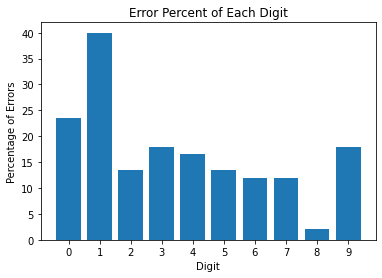

In [35]:
error_counts = get_error_counts(cm)

# Plot errors for mnist digits
plt.bar(range(10), 100*(np.array(error_counts[:10])/num_samples_per_class))
plt.xlabel('Digit')
plt.ylabel('Percentage of Errors')
plt.title('Error Percent of Each Digit')
plt.xticks(range(10), range(10))
plt.show()

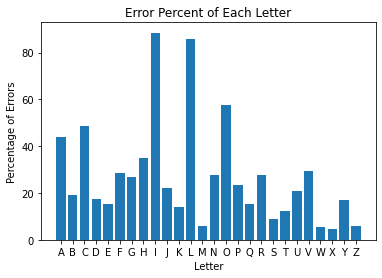

In [36]:
# Plot errors for emnist letters
plt.bar(range(26), 100*(np.array(error_counts[10:])/num_samples_per_class))
plt.xlabel('Letter')
plt.ylabel('Percentage of Errors')
plt.title('Error Percent of Each Letter')
plt.xticks(range(26), alphabet)
plt.show()

This is our preliminary results, we will improve the knn model through:

Cross-validation: Instead of splitting the data into a single training and testing set, we can use cross-validation to evaluate the model's performance on multiple test sets. This can provide a more robust estimate of the model's accuracy and help to prevent overfitting.

Feature scaling: it is important to ensure that all features contribute equally to the distance calculation. We can use scikit-learn's MinMaxScaler to scale the features to a common range.

Hyperparameter tuning: The k-NN algorithm has a hyperparameter k, which specifies the number of neighbors to consider when making a prediction. The optimal value of k can depend on the specific dataset and problem, so it's a good idea to tune this parameter using techniques such as grid search or randomized search.

Distance metric: The choice of distance metric can also have a significant impact on the performance of the k-NN algorithm. By default, scikit-learn uses the Euclidean distance metric, but other metrics such as Manhattan distance or cosine distance may be more appropriate for certain problems.

In our confusion matrix, we can see the number of correctly classified images for each digits, as well as a bar graph to better represent. From our basic model, digits 2 and 8 seems to produce the most errors, while 1 is the most accurate digit.

These are all things that we will implement in our knn model, before we design the neural network.


# Ethics & Privacy


One ethical concern we have with the MNIST dataset is the potential of bias within the dataset. What we mean by this is that there may be more samples of a certain digit compared to the rest, resulting in poor performance in that digit. Further, the intention of building this model using the MNIST dataset is to expand it to real applications, such as banks. With an architecture/evaluation metric that doesn't put weight on false positives, this could be lead to really catastrophic errors in the banking industry. For example, misidentifying a 4 or 9 can be a large difference, especially if it's a number like 400000 to 90000.

We plan to address this issue of bias by testing different model parameters such as data augmentation as well as changing the sampling strategy. For the other concern, we plan to use metrics that put weight on false postivies, including precision and f1 score. Then, we will use similarity metrics to actually see which digits are the most prone to these mistakes to allow this knowledge to be more widespread.

# Team Expectations 


* Be available on the weekends to work together if neccessary, otherwise individually complete assigned work during weekday
* Inform all team members through group chat on updates/something is pushed to github
* Finish all required parts at least 2 days before deadline is due

# Project Timeline Proposal



| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/16  |  1 PM |  Brainstorm topics/questions (all)  | Determine best form of communication; Discuss and decide on final project topic; discuss hypothesis; begin background research | 
| 2/17  |  10 AM |  Do background research on topic and come up with basic KNN model (George) | Discuss ideal dataset(s) and ethics; draft project proposal | 
| 2/17  | 10 PM  | Edit, finalize, and submit proposal; Search for datasets (Xinyao/Yingnan)  | Assign group members to lead each specific part   |
| 3/1  | 6 PM  | Begin Neural Network architecture design/programming(George) | Discuss Analysis Plan   |
| 3/2  | 12 PM  | Improve knn w/different parameters, explain changes (Yingnan) | Discuss/edit project code; Complete project |
| 3/12  | 12 PM  | Complete analysis; Draft results/conclusion/discussion (Xinyao)| Discuss/edit full project |
| 3/19  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes

<a name="adaptivelearningrate">1</a>: Luo, Liangchen (2019) Adaptive Gradient Methods with Dynamic Bound of Learning Rate. *ICLR 2019*. https://paperswithcode.com/paper/adaptive-gradient-methods-with-dynamic-bound<br> 

<a name="handwritten">2</a>: Matcha, Anil. 22 August 2022. How to easily do Handwriting Recognition using Machine Learning. *Nanonets*. https://nanonets.com/blog/handwritten-character-recognition/<br> 